#### Importação das bibliotecas

In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#### Carregamento e ajuste dos dados

In [282]:
df = pd.read_csv('./data/BTC-USD.csv')
df = df.iloc[2:,:]
df.head(10)

,Price,Close,High,Low,Open,Volume
2,2014-09-17,457.3340148925781,468.17401123046875,452.4219970703125,465.864013671875,21056800
3,2014-09-18,424.44000244140625,456.8599853515625,413.10400390625,456.8599853515625,34483200
4,2014-09-19,394.7959899902344,427.8349914550781,384.5320129394531,424.1029968261719,37919700
5,2014-09-20,408.90399169921875,423.2959899902344,389.88299560546875,394.6730041503906,36863600
6,2014-09-21,398.8210144042969,412.4259948730469,393.1809997558594,408.0849914550781,26580100
7,2014-09-22,402.1520080566406,406.9159851074219,397.1300048828125,399.1000061035156,24127600
8,2014-09-23,435.7909851074219,441.5570068359375,396.1969909667969,402.0920104980469,45099500
9,2014-09-24,423.2049865722656,436.11199951171875,421.1319885253906,435.7510070800781,30627700
10,2014-09-25,411.5740051269531,423.5199890136719,409.4679870605469,423.156005859375,26814400
11,2014-09-26,404.42498779296875,414.93798828125,400.0090026855469,411.4289855957031,21460800


In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 2 to 4019
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   4018 non-null   object
 1   Close   4018 non-null   object
 2   High    4018 non-null   object
 3   Low     4018 non-null   object
 4   Open    4018 non-null   object
 5   Volume  4018 non-null   object
dtypes: object(6)
memory usage: 188.5+ KB


Aqui notamos que estao todas as colunas com o tipo incorreto, vamos ajustar cada uma delas

In [284]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

Apliquei a função pd.to_numeric em cada uma dessas colunas que converte os valores pra número (float ou int)<br>
Se algum valor não puder ser convertido (por exemplo, "ABC", "?", "-"), o parâmetro errors='coerce' manda ele transformar em NaN (valor nulo)

In [285]:
df.dtypes

Price      object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

agora so falta colocar a coluna de data, para o tipo data

In [286]:
df = df.rename(columns={'Price': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [287]:
df = df.set_index('Date')
df = df.sort_index()

Agora já ajustei o nome da coluna, transformei para data, coloquei a data como indice do meu dataset e ordenei por garantia, porque vi que a ordem era importante para uma LSTM

In [288]:
df.head(15)

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
2014-09-22,402.152008,406.915985,397.130005,399.100006,24127600
2014-09-23,435.790985,441.557007,396.196991,402.092010,45099500
2014-09-24,423.204987,436.112000,421.131989,435.751007,30627700
2014-09-25,411.574005,423.519989,409.467987,423.156006,26814400


In [289]:
df.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [290]:
df[df.duplicated() == True]

,Close,High,Low,Open,Volume
Date,,,,,


#### Explorando um pouco os dados

In [291]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,4018.0,2.487618e+04,2.954574e+04,1.781030e+02,2.506395e+03,1.029073e+04,3.932764e+04,1.233441e+05
High,4018.0,2.536239e+04,3.004142e+04,2.117310e+02,2.571953e+03,1.046631e+04,4.023595e+04,1.244571e+05
Low,4018.0,2.431383e+04,2.897382e+04,1.715100e+02,2.387572e+03,1.002435e+04,3.811345e+04,1.189592e+05
Open,4018.0,2.484895e+04,2.951551e+04,1.768970e+02,2.494930e+03,1.028126e+04,3.930022e+04,1.233394e+05
Volume,4018.0,2.058300e+10,2.186031e+10,5.914570e+06,1.083760e+09,1.650599e+10,3.213259e+10,3.509679e+11


In [292]:
df.median().to_frame(name='median')

,median
Close,1.029073e+04
High,1.046631e+04
Low,1.002435e+04
Open,1.028126e+04
Volume,1.650599e+10


In [293]:
df.var().to_frame(name='var')

,var
Close,8.729507e+08
High,9.024867e+08
Low,8.394820e+08
Open,8.711655e+08
Volume,4.778730e+20


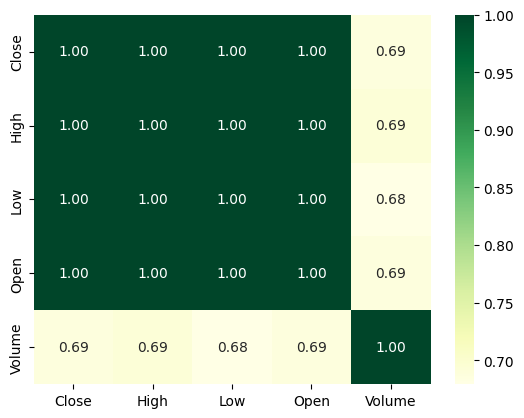

In [294]:
plt.Figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()


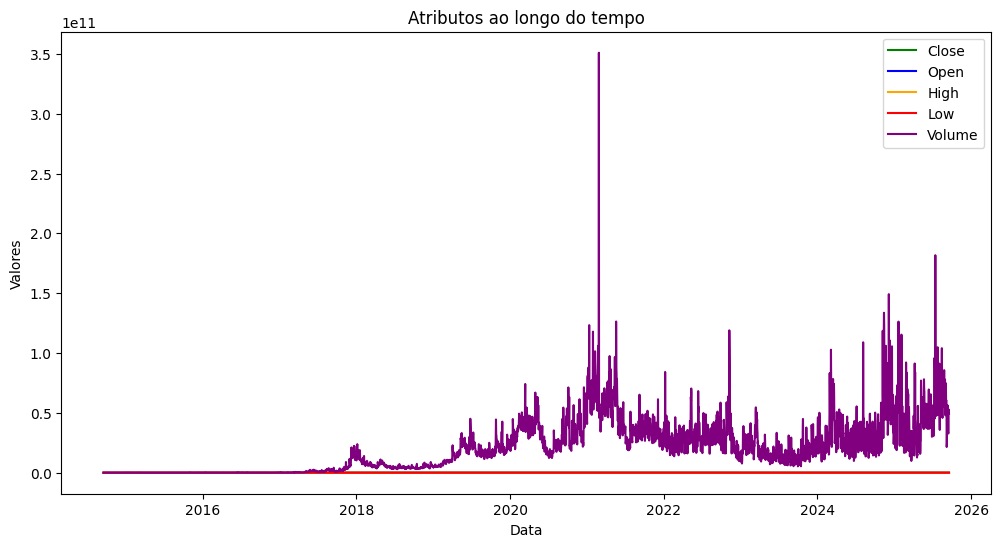

In [295]:
plt.figure(figsize=(12,6))

plt.plot(df.index, df['Close'], label='Close', color='green')
plt.plot(df.index, df['Open'], label='Open', color='blue')
plt.plot(df.index, df['High'], label='High', color='orange')
plt.plot(df.index, df['Low'], label='Low', color='red')
plt.plot(df.index, df['Volume'], label='Volume', color='purple')

plt.title('Atributos ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

Aqui nao conseguimos visualizar bem porque o valor do volume é bem superior aos demais, para melhor visualização vou normalizar os dados

In [298]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)
df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

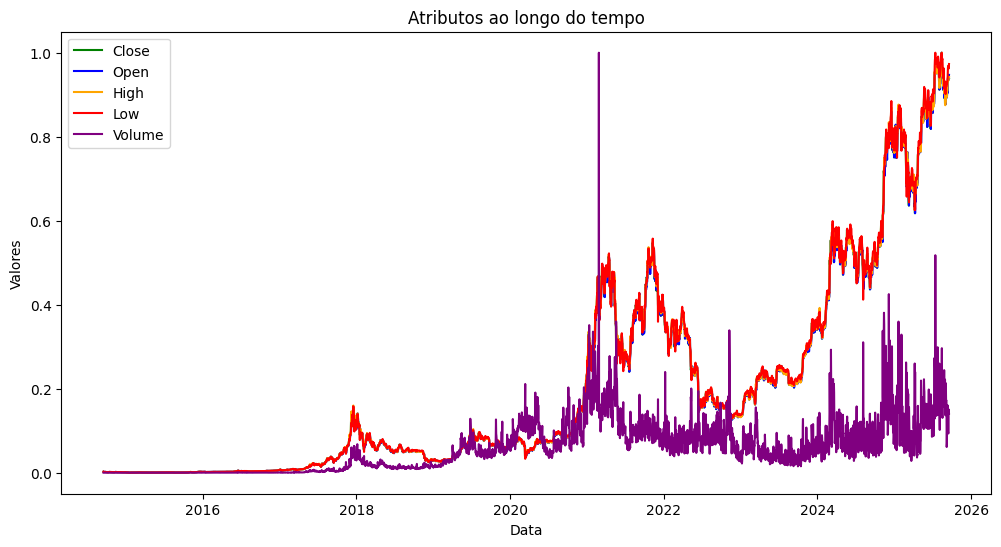

In [299]:
plt.figure(figsize=(12,6))

plt.plot(df.index, df['Close'], label='Close', color='green')
plt.plot(df.index, df['Open'], label='Open', color='blue')
plt.plot(df.index, df['High'], label='High', color='orange')
plt.plot(df.index, df['Low'], label='Low', color='red')
plt.plot(df.index, df['Volume'], label='Volume', color='purple')

plt.title('Atributos ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

podemos notar que close, open, high e low possuem praticamente a mesma tendencia como acusado pela matriz de correlação, já o volume tem o comportamento diferente, com picos e quedas meio bruscas